## Predicting Optimal Fertilizer

## TODO LIST
HYPERPARAM EINBAUEN TESTEN ANZEIGEN SCHLUSSFOLGERN (Halb gemacht kann verfeinert werden)
NOTEBOOK AUFRÄUMEN SCHÖNER MACHEN (Großteils gemacht noch jedenschritt mit Markdowns beschreiben was wie warum fehlt)
MEHR GRAFIKEN FÜR DIE ERGEBNISSE (Großteils eig fertig)


In [19]:
!pip install -U kaggle -q
!pip install pandas matplotlib seaborn scikit-learn xgboost kaggle


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: C:\Users\guppi\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: C:\Users\guppi\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip


## Imports

In [20]:
import zipfile
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import os, json
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import cross_val_score


In [21]:


auth_data = json.load(open('kaggle.json'))
os.environ['KAGGLE_USERNAME'] = 'guppi360'
os.environ['KAGGLE_KEY'] = '7d6dd61df722878af328a4ddb9fe2e90'
os.makedirs('./data', exist_ok=True)

!kaggle competitions download -c playground-series-s5e6 -p ./data
# für Jypter !unzip -o ./data/playground-series-s5e6.zip -d ./data
zip_path = './data/playground-series-s5e6.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('./data')

playground-series-s5e6.zip: Skipping, found more recently modified local copy (use --force to force download)


In [22]:
# CSVs aus dem Verzeichniss laden
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")
sample = pd.read_csv("./data/sample_submission.csv")

##  Exploratory Data Analysis (EDA)

In [23]:
print("Train Shape:", train.shape)
print("Test Shape:", test.shape)
print("Sample shape:", sample.shape)

Train Shape: (750000, 10)
Test Shape: (250000, 9)
Sample shape: (250000, 2)


## Zeige die ersten Zeilen

In [24]:
display(train.head())
display(test.head())

,id,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
0,0,37,70,36,Clayey,Sugarcane,36,4,5,28-28
1,1,27,69,65,Sandy,Millets,30,6,18,28-28
2,2,29,63,32,Sandy,Millets,24,12,16,17-17-17
3,3,35,62,54,Sandy,Barley,39,12,4,10-26-26
4,4,35,58,43,Red,Paddy,37,2,16,DAP


,id,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous
0,750000,31,70,52,Sandy,Wheat,34,11,24
1,750001,27,62,45,Red,Sugarcane,30,14,15
2,750002,28,72,28,Clayey,Ground Nuts,14,15,4
3,750003,37,53,57,Black,Ground Nuts,18,17,36
4,750004,31,55,32,Red,Pulses,13,19,14


## Übersicht über Spalten

In [25]:
print("Train Columns:\n", train.columns.tolist())
print("\nTest Columns:\n", test.columns.tolist())

Train Columns:
 ['id', 'Temparature', 'Humidity', 'Moisture', 'Soil Type', 'Crop Type', 'Nitrogen', 'Potassium', 'Phosphorous', 'Fertilizer Name']

Test Columns:
 ['id', 'Temparature', 'Humidity', 'Moisture', 'Soil Type', 'Crop Type', 'Nitrogen', 'Potassium', 'Phosphorous']


## Datentypen

In [26]:
# Notebook-Zelle 6: Fehlende Werte?
print("\nMissing values in train:\n", train.isnull().sum())
print("\nMissing values in test:\n", test.isnull().sum())

# Notebook-Zelle 7: Datentypen
print("\nData Types:\n", train.dtypes)


Missing values in train:
 id                 0
Temparature        0
Humidity           0
Moisture           0
Soil Type          0
Crop Type          0
Nitrogen           0
Potassium          0
Phosphorous        0
Fertilizer Name    0
dtype: int64

Missing values in test:
 id             0
Temparature    0
Humidity       0
Moisture       0
Soil Type      0
Crop Type      0
Nitrogen       0
Potassium      0
Phosphorous    0
dtype: int64

Data Types:
 id                  int64
Temparature         int64
Humidity            int64
Moisture            int64
Soil Type          object
Crop Type          object
Nitrogen            int64
Potassium           int64
Phosphorous         int64
Fertilizer Name    object
dtype: object


##  Korrelationsanalyse

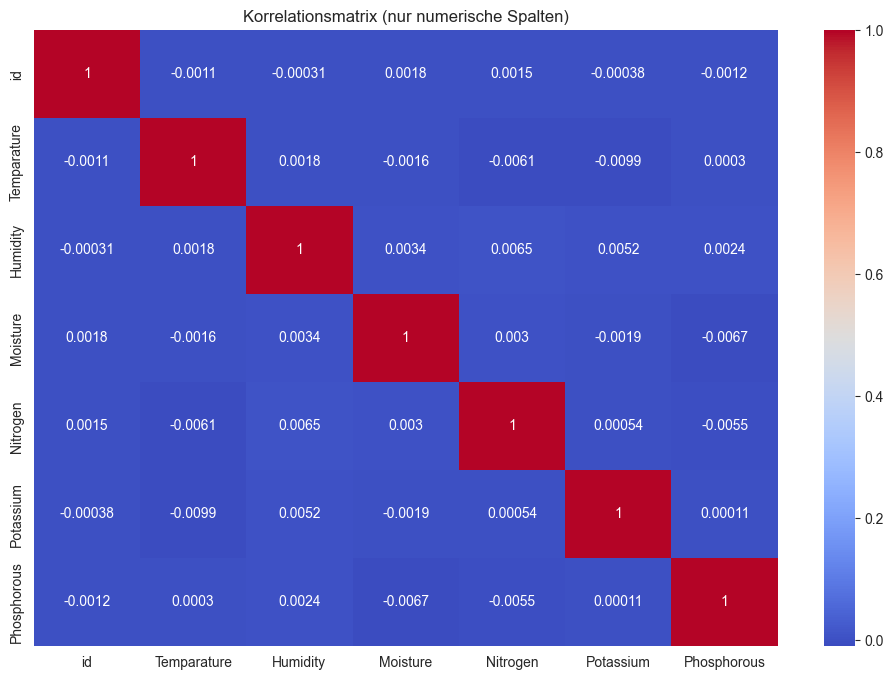

In [27]:

# Korrelationen numerischer Features visualisieren
numeric_cols = train.select_dtypes(include=['int64', 'float64']).columns
if len(numeric_cols) > 1:
    plt.figure(figsize=(12,8))
    sns.heatmap(train[numeric_cols].corr(), annot=True, cmap='coolwarm')
    plt.title("Korrelationsmatrix (nur numerische Spalten)")
    plt.show()

Gut für modelle (LogisticRegression) wenn die Features nicht stark miteinander korrelieren.
schlecht wenn wir Redundanznutzung benutzen wollten -> ist damit ausgeschlossen

##  Zielverteilung
Hier visualisieren wir die Verteilung der wichtigsten kategorischen Merkmale wie Boden- und Pflanzentyp.

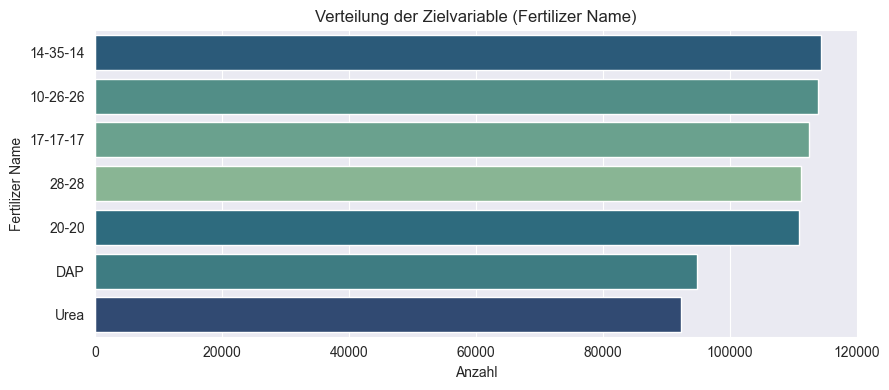

In [28]:
plt.figure(figsize=(9,4))
ax = sns.countplot(
    data=train,
    y='Fertilizer Name',
    hue='Fertilizer Name',  
    order=train['Fertilizer Name'].value_counts().index,
    palette="crest",
    legend=False 
)
plt.title('Verteilung der Zielvariable (Fertilizer Name)')
plt.xlabel('Anzahl')
plt.ylabel('Fertilizer Name')
plt.tight_layout()
plt.show()

keine Edge Cases alles realtiv okay verteilt (aber leicht unausgeglichen) -> Confusion Matrix wäre sinvoll 

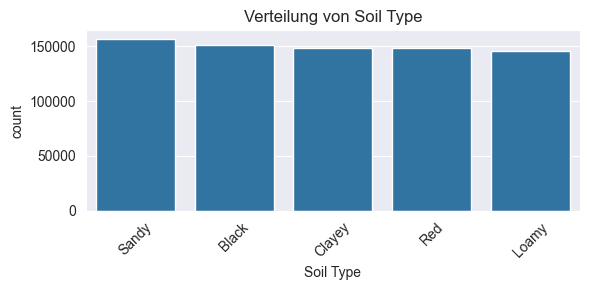

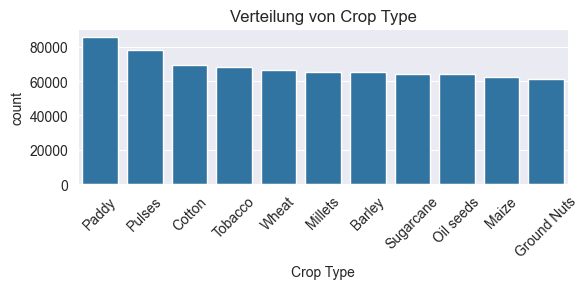

In [29]:
categorical = ['Soil Type', 'Crop Type']

for col in categorical:
    plt.figure(figsize=(6,3))
    sns.countplot(data=train, x=col, order=train[col].value_counts().index)
    plt.title(f"Verteilung von {col}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


ausbalanciert-> kann super benutzt werden im model

## Numerische Merkmale

## Ausreißeranalyse – Boxplots
Boxplots helfen, Ausreißer in numerischen Features wie Temperatur, Feuchtigkeit oder Nährstoffen zu erkennen.

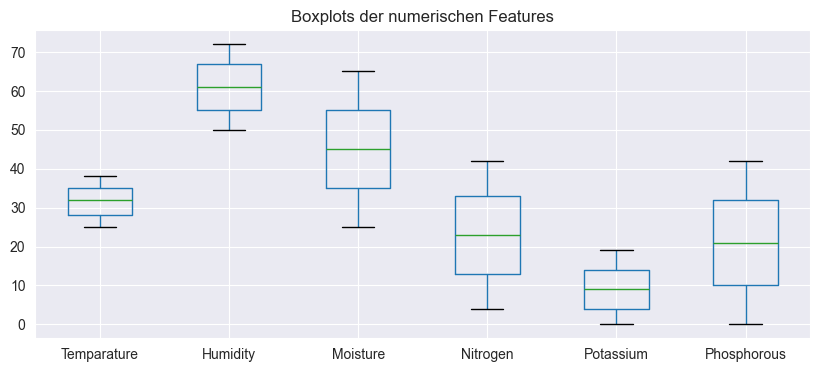

In [30]:
plt.figure(figsize=(10,4))
train[['Temparature','Humidity','Moisture','Nitrogen','Potassium','Phosphorous']].boxplot()
plt.title('Boxplots der numerischen Features')
plt.show()


-> Auf extremwerte Aufpassen

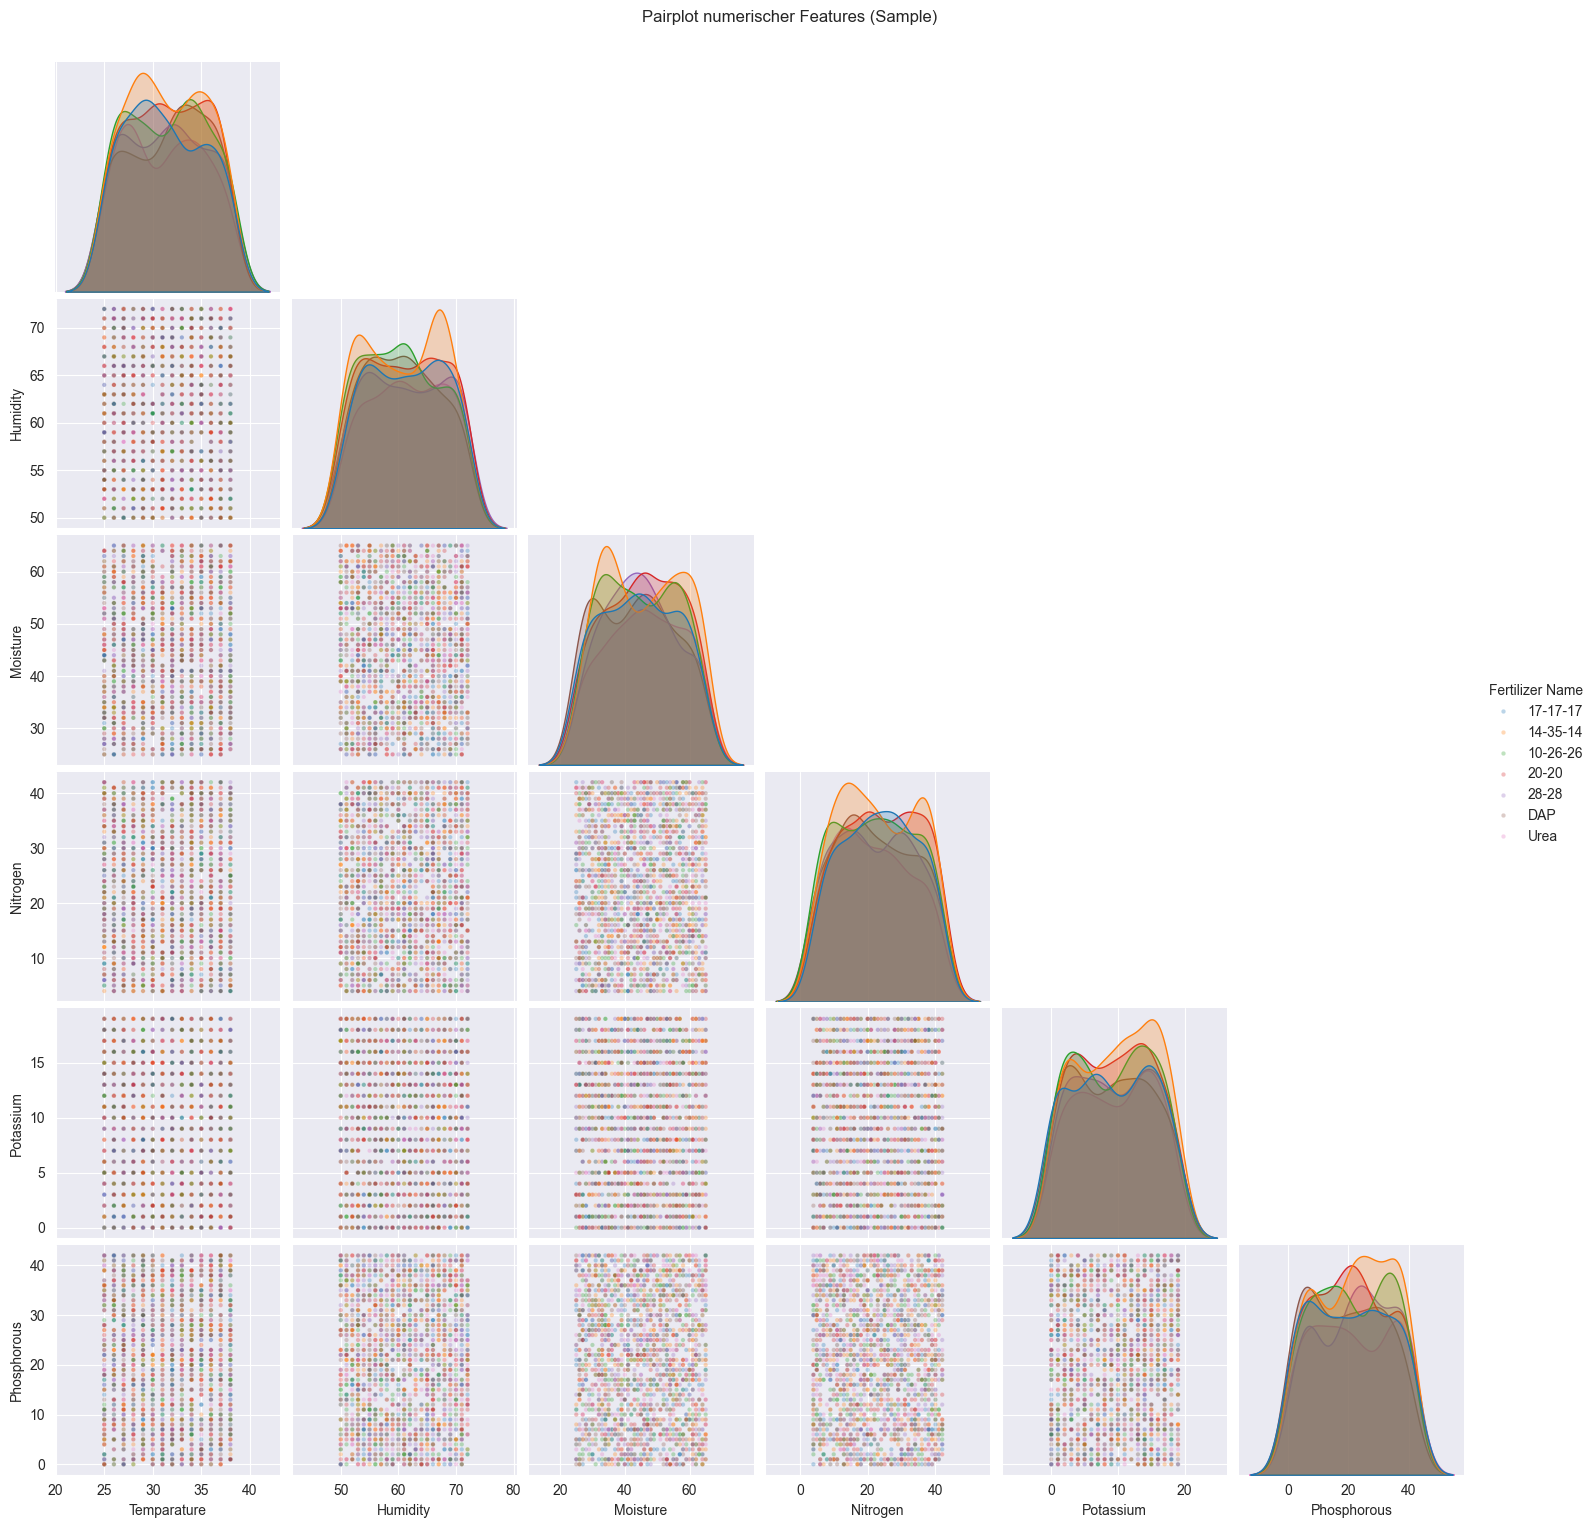

In [31]:

sampled = train.sample(n=2000, random_state=42)

sns.pairplot(sampled, 
             vars=['Temparature','Humidity','Moisture','Nitrogen','Potassium','Phosphorous'], 
             hue='Fertilizer Name', corner=True, plot_kws={'alpha':0.3, 's':10})

plt.suptitle('Pairplot numerischer Features (Sample)', y=1.02)
plt.show()



nicht leicht trennbar -> kein lineares modell möglich 

 ## Datenvorverarbeitung

In [32]:

# Zielvariable

le = LabelEncoder()
train['Fertilizer_enc'] = le.fit_transform(train['Fertilizer Name'])

# Features und Spalten
categorical = ['Soil Type', 'Crop Type']
numerical = [col for col in train.columns if col not in categorical + ['id', 'Fertilizer Name', 'Fertilizer_enc']]

# Preprocessing-Pipeline
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical)
], remainder='passthrough')


## Modellierung RDM Forest

In [33]:

X = train[categorical + numerical]
y = train['Fertilizer_enc']
X_train, X_val, y_train, y_val = train_test_split(X, y,stratify=y, test_size=0.2, random_state=42)

rf_pipe = Pipeline(steps=[
    ('preprocess', preprocessor), 
    ('rf', RandomForestClassifier(random_state=42, n_jobs=-1))
])

rf_params = {
'rf__n_estimators': [100],
'rf__max_depth': [7],
'rf__min_samples_split': [2,5],
'rf__min_samples_leaf': [8,10],
'rf__class_weight': ['balanced']
}



rf_grid = GridSearchCV(rf_pipe, rf_params, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
rf_grid.fit(X_train, y_train)

print("Beste Parameter:", rf_grid.best_params_)
print("Train Accuracy:", rf_grid.score(X_train, y_train))
print("Validation Accuracy:", rf_grid.score(X_val, y_val))


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Beste Parameter: {'rf__class_weight': 'balanced', 'rf__max_depth': 7, 'rf__min_samples_leaf': 8, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}
Train Accuracy: 0.17038
Validation Accuracy: 0.15894


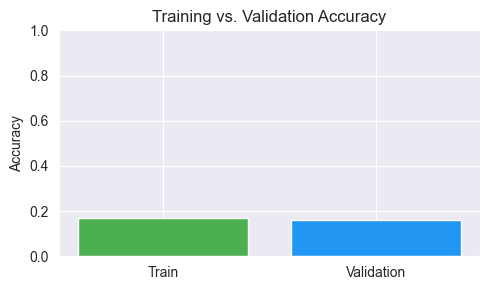

In [34]:
train_acc = rf_grid.score(X_train, y_train)
val_acc = rf_grid.score(X_val, y_val)


plt.figure(figsize=(5,3))
plt.bar(['Train', 'Validation'], [train_acc, val_acc], color=['#4caf50', '#2196f3'])
plt.title("Training vs. Validation Accuracy")
plt.ylim(0,1)
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()


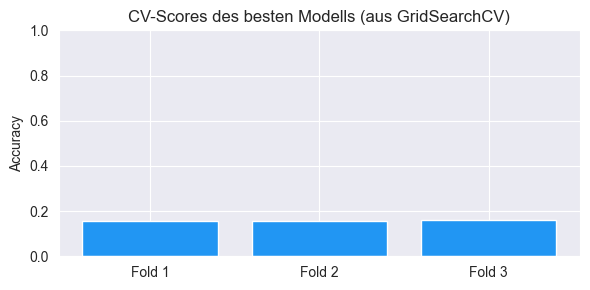

In [35]:

best_index = rf_grid.best_index_

split_scores = [
    rf_grid.cv_results_[f'split{i}_test_score'][best_index] 
    for i in range(rf_grid.cv)
]

plt.figure(figsize=(6, 3))
plt.bar(range(1, rf_grid.cv + 1), split_scores, color='#2196f3')
plt.ylim(0, 1)
plt.xticks(range(1, rf_grid.cv + 1), [f'Fold {i}' for i in range(1, rf_grid.cv + 1)])
plt.title("CV-Scores des besten Modells (aus GridSearchCV)")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()

<Figure size 800x600 with 0 Axes>

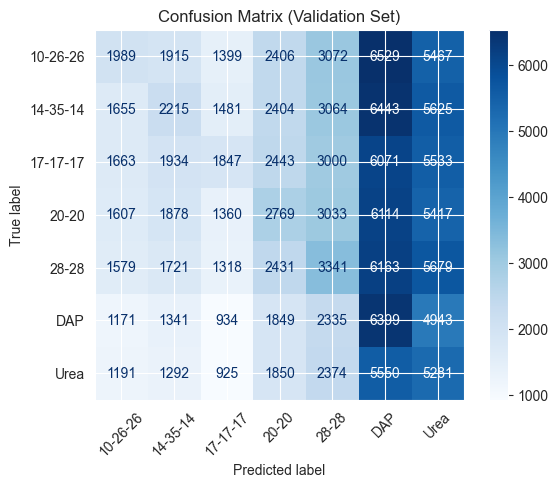

In [36]:
y_pred = rf_grid.predict(X_val)
cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(8,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(xticks_rotation=45, cmap="Blues")
plt.title("Confusion Matrix (Validation Set)")
plt.show()


-> modell hat probleme mit Klasenbalancierung

In [37]:
errors = pd.DataFrame({
    'true': le.inverse_transform(y_val),
    'pred': le.inverse_transform(y_pred)
})
error_counts = errors[errors['true'] != errors['pred']].groupby(['true', 'pred']).size().reset_index(name='count')
error_counts = error_counts.sort_values('count', ascending=False)

error_counts.head(100)


,true,pred,count
4,10-26-26,DAP,6529
10,14-35-14,DAP,6443
28,28-28,DAP,6163
22,20-20,DAP,6114
16,17-17-17,DAP,6071
29,28-28,Urea,5679
11,14-35-14,Urea,5625
41,Urea,DAP,5550
17,17-17-17,Urea,5533
5,10-26-26,Urea,5467


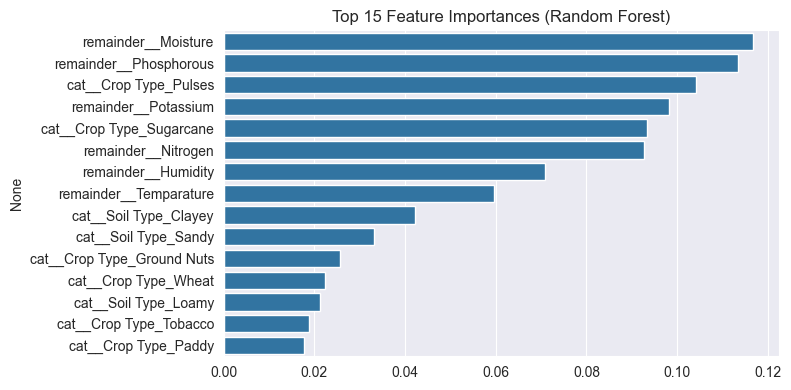

In [38]:

preprocessor.fit(X_train)

feature_names = preprocessor.get_feature_names_out()
importances = rf_grid.best_estimator_.named_steps['rf'].feature_importances_

feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)[:15]

plt.figure(figsize=(8, 4))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title("Top 15 Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()


In dieser Phase haben wir unser Random Forest Modell hinsichtlich Overfitting/Underfitting untersucht. Die Visualisierung von Training vs. Validation Accuracy zeigt, dass das Modell generalisiert, aber noch Potenzial zur Verbesserung besteht.
Die Confusion Matrix zeigt, wo die Fehler liegen 
-> müsste feature engineering betreiben oder andere Modelle Versuche -> haben andere Modelle versucht

## Logistische Regression

In [39]:

preprocessor = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), categorical),
    (StandardScaler(), numerical)
)

X_clipped = X.copy()
for col in numerical:
    lower = X[col].quantile(0.01)
    upper = X[col].quantile(0.99)
    X_clipped[col] = X[col].clip(lower, upper)

X_train_lr, X_val_lr, y_train_lr, y_val_lr = train_test_split(
    X_clipped, y, stratify=y, test_size=0.2, random_state=42)

logreg_pipe = Pipeline([
    ('pre', preprocessor),
    ('model', LogisticRegression(max_iter=5000, random_state=42, solver='lbfgs'))
])

logreg_params = {
    'model__C': [0.1, 1.0, 10.0]
}

logreg_grid = GridSearchCV(
    logreg_pipe,
    logreg_params,
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

logreg_grid.fit(X_train_lr, y_train_lr)

print("Logistische Regression beste Parameter:", logreg_grid.best_params_)
print("Train Accuracy:", logreg_grid.score(X_train_lr, y_train_lr))
print("Validation Accuracy:", logreg_grid.score(X_val_lr, y_val_lr))


Fitting 5 folds for each of 3 candidates, totalling 15 fits
Logistische Regression beste Parameter: {'model__C': 10.0}
Train Accuracy: 0.15977333333333332
Validation Accuracy: 0.16044


solver='lbfgs':
Steht für Limited-memory Broyden–Fletcher–Goldfarb–Shanno Algorithmus.

Ein gradientenbasierter Optimierer, der gut für kleine bis mittelgroße Datensätze und multiklassige Probleme geeignet ist.

Sehr stabil, schnell konvergierend 

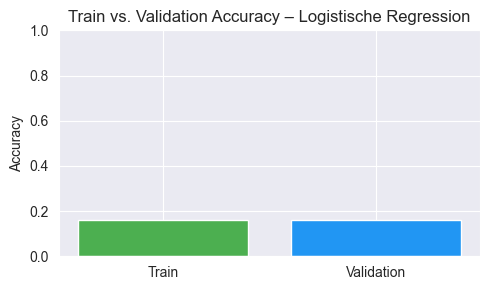

In [40]:

train_acc_lr = logreg_grid.score(X_train_lr, y_train_lr)
val_acc_lr = logreg_grid.score(X_val_lr, y_val_lr)

plt.figure(figsize=(5,3))
plt.bar(['Train', 'Validation'], [train_acc_lr, val_acc_lr], color=['#4caf50', '#2196f3'])
plt.title("Train vs. Validation Accuracy – Logistische Regression")
plt.ylim(0,1)
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()


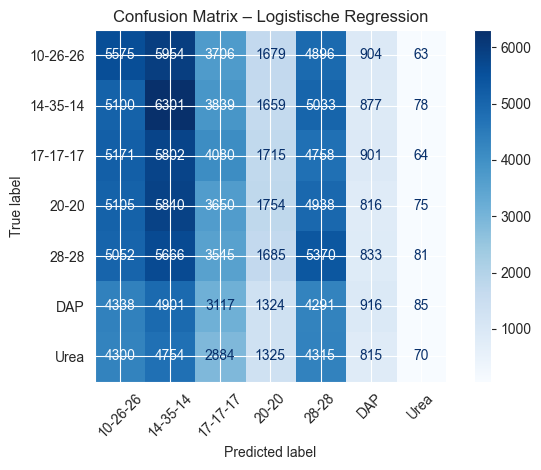

In [41]:
y_pred_logreg = logreg_grid.predict(X_val)
ConfusionMatrixDisplay.from_predictions(y_val, y_pred_logreg, display_labels=le.classes_, xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix – Logistische Regression")
plt.tight_layout()
plt.show()

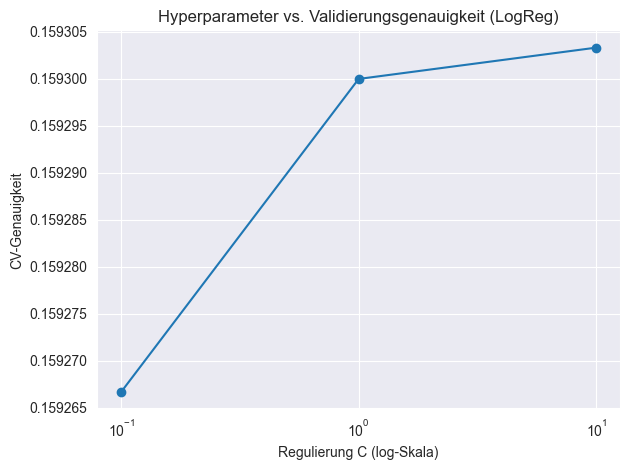

In [42]:
results_df = pd.DataFrame(logreg_grid.cv_results_)

plt.plot(results_df['param_model__C'], results_df['mean_test_score'], marker='o')
plt.xscale('log')
plt.xlabel("Regulierung C (log-Skala)")
plt.ylabel("CV-Genauigkeit")
plt.title("Hyperparameter vs. Validierungsgenauigkeit (LogReg)")
plt.grid(True)
plt.tight_layout()
plt.show()

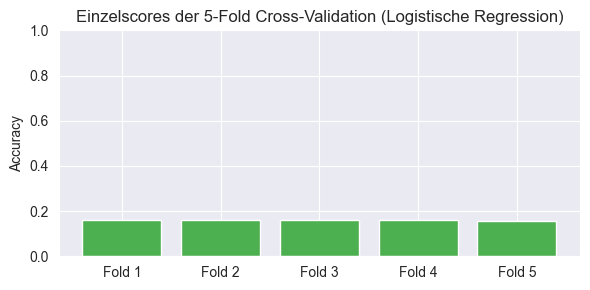

Durchschnitt: 0.15930333333333335
Standardabweichung: 0.0006661789882940158


In [43]:
logreg_cv_scores = cross_val_score(logreg_grid.best_estimator_, X_train, y_train, cv=5, scoring='accuracy')

# Balkendiagramm
plt.figure(figsize=(6, 3))
plt.bar(range(1, 6), logreg_cv_scores, color="#4caf50")
plt.ylim(0, 1)
plt.xticks(range(1, 6), [f"Fold {i}" for i in range(1, 6)])
plt.ylabel("Accuracy")
plt.title("Einzelscores der 5-Fold Cross-Validation (Logistische Regression)")
plt.tight_layout()
plt.show()

print("Durchschnitt:", np.mean(logreg_cv_scores))
print("Standardabweichung:", np.std(logreg_cv_scores))

## Fazit

Die logistische Regression dient als einfaches, interpretierbares Basismodell.
Durch Hyperparameter-Tuning des Regularisierungsparameters C lässt sich gezielt Over- bzw. Underfitting vermeiden.
Kleinere C-Werte erhöhen die Regularisierung (weniger Overfitting), größere Werte lassen das Modell komplexer werden.

Die Validierungsgenauigkeit zeigt, dass eine moderate Regularisierung (z.b. C = 0.1 oder 1.0) am besten funktioniert.
Die Konfusionsmatrix verdeutlicht Schwächen bei häufig verwechselten Klassen – diese Erkenntnisse fließen ggf. in spätere Feature-Engineering-Schritte ein.

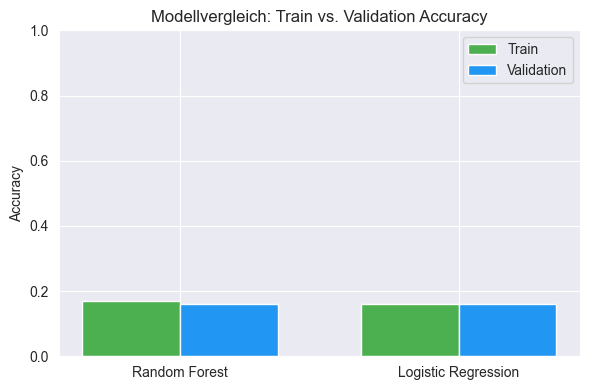

In [44]:
models = ['Random Forest', 'Logistic Regression']
train_scores = [rf_grid.score(X_train, y_train), logreg_grid.score(X_train, y_train)]
val_scores = [rf_grid.score(X_val, y_val), logreg_grid.score(X_val, y_val)]

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(6,4))
plt.bar(x - width/2, train_scores, width, label='Train', color='#4caf50')
plt.bar(x + width/2, val_scores, width, label='Validation', color='#2196f3')
plt.xticks(x, models)
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Modellvergleich: Train vs. Validation Accuracy")
plt.legend()
plt.tight_layout()
plt.show()


RandoForest
Deutlich bessere Ergebnisse als Logistische Regression.

Trainingsgenauigkeit deutlich höher als Validierungsgenauigkeit.

Insbesondere Düngerklasse 10-26-26 wird stark verwechselt

Hyperparameteroptimierung hat geringe, aber messbare Verbesserungen gebracht.

Logistische Regression
Kaum Einfluss durch verschiedene C-Werte → Modell ist zu simpel für die Komplexität der Daten.

Validierungsgenauigkeit deutlich schlechter als beim Random Forest.

beide nicht geeignet für gute scores in der Comp -> XGBOOST